# Capstone Project

## Park Slope Parents Membership

For this portion of the project I'm going to be making a classification model to determine whether someone is likely to be a long term or short term member.

The first step is figuring out where that line is. 

Median membership is 2 years, which is also close to the threshold I saw was when many folks check out relative to their child's birth (22 months). This seems like the ideal choice.

I'll also be doing a cluster analysis, because I love those.

In [563]:
# Load libraries

from datetime import datetime, date, timedelta

# import matplotlib.pyplot as plt
# %matplotlib inline

# from IPython.display import HTML
# from matplotlib import cm as cm
# from mpl_toolkits.mplot3d import Axes3D
# from pandas.io import sql
# from sklearn import metrics
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
# from sklearn.decomposition import PCA 
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
# from sqlalchemy import create_engine
import csv
import numpy as np
import pandas as pd 
# import patsy
# import plotly.graph_objs as go
# import plotly.plotly as py
# from plotly.tools import FigureFactory as FF
# from plotly.graph_objs import graph_objs
# import psycopg2 as psy
# import scipy
# import seaborn as sns
# import sklearn
import statsmodels.api as sm
# py.sign_in('ajbentley', 'zjfu2vasav')
# plt.style.use('fivethirtyeight')
# wine_palette = sns.xkcd_palette(['dandelion', 'claret'])

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [564]:
# read in data

dfn = pd.read_csv("../../projects/psp/raw_data/PSP_data_4capstone.csv")
dfn.info()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14914 entries, 0 to 14913
Data columns (total 23 columns):
mem_no                14914 non-null object
address               14914 non-null object
city                  14914 non-null object
state                 14914 non-null object
zip                   14914 non-null int64
joined                14914 non-null object
exp_date              14914 non-null object
status                14914 non-null object
mem_type              14914 non-null object
last_renewal_date     14914 non-null object
gender                14914 non-null object
club_email            14914 non-null object
dup                   14914 non-null object
parent_status         14914 non-null object
kid_count             14914 non-null float64
kid1_bday             14914 non-null object
kid2_bday             14914 non-null object
join_reason           10144 non-null object
advice_grp            14914 non-null int64
classifieds           14914 non-null int64
classifieds_s

,mem_no,address,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,...,parent_status,kid_count,kid1_bday,kid2_bday,join_reason,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,438_12th_street,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,...,Yes,2.0,4/14/85,4/14/85,dfs,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,580_5th_street,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,...,Yes,2.0,12/11/02,12/11/02,NaN,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,502_13th_st,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,...,Yes,2.0,1/1/01,1/1/01,no,1,1,0,No,Other
3,00118,1512_10th_ave,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,...,Yes,2.0,5/17/02,9/14/04,This is a renewal,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,434_13th_st,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,...,Yes,2.0,10/5/01,7/31/07,"Yes, I'm in love with you, Susan Fox! :-)",1,1,0,Yes,A PSP member who is a friend/neighbor


In [565]:
# # not all types carried over from when the data was saved (datetime in particular, which
# # pleases me not at all).

dfn.joined = pd.to_datetime(dfn.joined, format='%Y/%m/%d')
dfn.exp_date = pd.to_datetime(dfn.exp_date, format='%Y/%m/%d')
dfn.last_renewal_date = pd.to_datetime(dfn.last_renewal_date, format='%Y/%m/%d')
dfn.kid1_bday = pd.to_datetime(dfn.kid1_bday, format='%m/%d/%y')
dfn.kid2_bday = pd.to_datetime(dfn.kid2_bday, format='%m/%d/%y')

In [566]:
# getting rid of address and join reason

dfn.drop(["address",'join_reason'], axis=1, inplace=True)

dfn.head()

,mem_no,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,...,dup,parent_status,kid_count,kid1_bday,kid2_bday,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,...,NO,Yes,2.0,1985-04-14,1985-04-14,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,...,NO,Yes,2.0,2002-12-11,2002-12-11,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,...,YES,Yes,2.0,2001-01-01,2001-01-01,1,1,0,No,Other
3,00118,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,...,NO,Yes,2.0,2002-05-17,2004-09-14,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,...,YES,Yes,2.0,2001-10-05,2007-07-31,1,1,0,Yes,A PSP member who is a friend/neighbor


In [567]:
# columns for joined month and year

dfn['join_year'] = dfn['joined'].dt.year
dfn['join_month'] = dfn['joined'].dt.month

# columns for exp_date year

dfn['exp_year'] = dfn['exp_date'].dt.year

# # columns for 1st kid's birth month and year
dfn['k1bday_year'] = dfn['kid1_bday'].dt.year
dfn['k1bday_month'] = dfn['kid1_bday'].dt.month

# # columns for 2nd kid's birth month and year
dfn['k2bday_year'] = dfn['kid2_bday'].dt.year
dfn['k2bday_month'] = dfn['kid2_bday'].dt.month


dfn.head()

,mem_no,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,...,classifieds_spouse,tony_kids,discovered,join_year,join_month,exp_year,k1bday_year,k1bday_month,k2bday_year,k2bday_month
0,00002,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,...,1,Yes,A PSP member who is a friend/neighbor,2009,2,2020,1985,4,1985,4
1,00004,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,...,0,Yes,A PSP member I don't know told me about it,2009,4,2020,2002,12,2002,12
2,00101,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,...,0,No,Other,2002,7,2014,2001,1,2001,1
3,00118,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,...,0,No,A PSP member who is a friend/neighbor,2002,8,2017,2002,5,2004,9
4,00121,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,...,0,Yes,A PSP member who is a friend/neighbor,2002,8,2019,2001,10,2007,7


In [568]:
# check dates for out of consideration range. basically for grandparents who are using their children's birth dates,
# not their grandchildren's. Org started in 2002 so will assume anything prior to 1990 will be out of range

dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] < 2018])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] < 2018])

In [569]:
# adding column for membership duration
# in order to convert the timedelta result I divided by 6.048E+14 which gives me weeks as integers (just trust me)

dfn['mem_duration'] = ((dfn['exp_date'] - dfn['joined'])/604800000000000).astype(int)

In [570]:
# creating dummies for over/under 2 years

# md of 1 == n is a long term member

md = []

for n in dfn.mem_duration:
    if n > 104:
        md.append(1)
    else:
        md.append(0)

In [571]:
dfn=dfn.set_index(md_s.index)
# dfn['long_short'] = md_s.iloc[:,0].values
dfn['long_short']=md_s

In [572]:
# creating df for diff b/n birth and join

jvbcols = ['joined','kid1_bday']

jvb_df = pd.DataFrame(dfn[jvbcols])

jvb_df.head()
jvb_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 2 columns):
joined       14591 non-null datetime64[ns]
kid1_bday    14591 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 228.1 KB


In [573]:
# create column for jvb

jvb_df['jvb'] = (jvb_df['joined']-jvb_df['kid1_bday'])
print jvb_df.info()
jvb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 3 columns):
joined       14591 non-null datetime64[ns]
kid1_bday    14591 non-null datetime64[ns]
jvb          14591 non-null timedelta64[ns]
dtypes: datetime64[ns](2), timedelta64[ns](1)
memory usage: 342.0 KB
None


,joined,kid1_bday,jvb
0,2009-04-13,2002-12-11,2315 days
1,2002-07-17,2001-01-01,562 days
2,2002-08-13,2002-05-17,88 days
3,2002-08-26,2001-10-05,325 days
4,2002-08-28,2002-07-18,41 days


In [574]:
# drop base columns, leaving just the calculated one

jvb_df.drop(['joined','kid1_bday'], axis=1, inplace=True)
print jvb_df.info()
jvb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 1 columns):
jvb    14591 non-null timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 114.1 KB
None


,jvb
0,2315 days
1,562 days
2,88 days
3,325 days
4,41 days


In [575]:
# change calc to int 

jvb_df['jvb2'] = jvb_df['jvb']/timedelta(1)

In [576]:
jvb_df.pop('jvb');

In [577]:
# get dummies for whether a child was born before or after membership

# if a family joined before their child was born x == 1

def positive(x):
    if x <= 1:
        return 0
    else:
        return 0
    
jvb_df['jvb_pre'] = jvb_df['jvb2'].apply(positive);


In [578]:
jvb_pre_post = pd.Series(jvb_df['jvb_pre']);

In [579]:
# jvb_pre = []

# for n in jvb_df.jvb2:
#     if n >= 0:
#         jvb_pre.append(1)
#     else:
#         jvb_pre.append(0)

# len(jvb_pre)

In [580]:
# add jvb_df to dfn

dfn = pd.concat([dfn, jvb_pre_post], axis=1)
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 31 columns):
mem_no                14591 non-null object
city                  14591 non-null object
state                 14591 non-null object
zip                   14591 non-null int64
joined                14591 non-null datetime64[ns]
exp_date              14591 non-null datetime64[ns]
status                14591 non-null object
mem_type              14591 non-null object
last_renewal_date     14591 non-null datetime64[ns]
gender                14591 non-null object
club_email            14591 non-null object
dup                   14591 non-null object
parent_status         14591 non-null object
kid_count             14591 non-null float64
kid1_bday             14591 non-null datetime64[ns]
kid2_bday             14591 non-null datetime64[ns]
advice_grp            14591 non-null int64
classifieds           14591 non-null int64
classifieds_spouse    14591 non-null int64
tony_kids         

In [581]:
# adding long-

# dfn=dfn.set_index(md_s.index)
# dfn['long_short']=md_s

# jwp_s = pd.Series(jwp)
        
# dfn = pd.concat([dfn, jwp_s])
# dfn.rename (columns={0:'pre-post-birth'}, inplace=True)
        
# added a nan row for some reason
# dfn = dfn.ix[1:]

In [582]:
# creating a new column which shows the difference between the member's
# expiration date and the 2nd child's birthday (defaults to 1st child if no second)

dfn['exp_v_birth'] = (dfn['exp_date']-dfn['kid2_bday']).astype('timedelta64[m]')

In [583]:
# cutting this to all numeric

dfn.drop(['city','state','mem_type','status'], axis=1, inplace=True)

In [584]:
# make a few dummies
# patsy would be easier--relearn



dup_dummy = pd.get_dummies(dfn['dup'], prefix='dup')
parent_dummy = pd.get_dummies(dfn['parent_status'], prefix='parent_status')
gender_dummy = pd.get_dummies(dfn['gender'], prefix='gender')
email_dummy = pd.get_dummies(dfn['club_email'], prefix='club_email')
advice_dummy = pd.get_dummies(dfn['advice_grp'], prefix='advice_grp')
classifieds_dummy = pd.get_dummies(dfn['classifieds'], prefix='classifieds')
class_sp_dummy = pd.get_dummies(dfn['classifieds_spouse'], prefix='classifieds_spouse')
tony_dummy = pd.get_dummies(dfn['tony_kids'], prefix='tony_kids')
disc_dummy = pd.get_dummies(dfn['discovered'], prefix='discovered')
kidcount_dummy = pd.get_dummies(dfn['kid_count'], prefix='kid_count')



dfn = dfn.join(dup_dummy)
dfn = dfn.join(parent_dummy)
dfn = dfn.join(gender_dummy)
dfn = dfn.join(email_dummy)
dfn = dfn.join(advice_dummy)
dfn = dfn.join(classifieds_dummy)
dfn = dfn.join(class_sp_dummy)
dfn = dfn.join(tony_dummy)
dfn = dfn.join(disc_dummy)
dfn = dfn.join(kidcount_dummy)

In [585]:
print dfn.info()
print ' '
# print dfn.describe()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 59 columns):
mem_no                                                                            14591 non-null object
zip                                                                               14591 non-null int64
joined                                                                            14591 non-null datetime64[ns]
exp_date                                                                          14591 non-null datetime64[ns]
last_renewal_date                                                                 14591 non-null datetime64[ns]
gender                                                                            14591 non-null object
club_email                                                                        14591 non-null object
dup                                                                               14591 non-null object
parent_status                       

,mem_no,zip,joined,exp_date,last_renewal_date,gender,club_email,dup,parent_status,kid_count,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_I don't remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,00004,11215,2009-04-13,2020-04-12,2009-04-13,Female,Yes,NO,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
1,00101,11215,2002-07-17,2014-09-15,2002-07-17,Female,Yes,YES,Yes,2.0,...,0,0,0,1,0,0,0,1,0,0
2,00118,11215,2002-08-13,2017-06-15,2002-08-13,Female,Yes,NO,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
3,00121,11215,2002-08-26,2019-06-16,2002-08-26,Female,Yes,YES,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
4,00122,11215,2002-08-28,2017-06-20,2002-08-28,Female,Yes,YES,Yes,1.0,...,0,0,0,0,0,0,1,0,0,0


In [586]:
# dfn.set_index('mem_no')

Now the data is all set and we're ready to model.

There's definitely going to be a ton of colinearity among these features.


In [587]:
dfn_r = pd.DataFrame(dfn)

In [588]:
# drop datetime columns
dfn_r.drop(['joined','exp_date','last_renewal_date','kid1_bday','kid2_bday','k1bday_year','k2bday_year'], axis=1, inplace=True)

# drop columns that are specifically date-related (since we're predicting time) and mem_no, since that is meaningless
dfn_r.drop(['mem_no','join_year','exp_year','mem_duration','exp_v_birth','dup_NO','dup_YES'], axis=1, inplace=True)

# dropping all parent status because you have to be a parent or expecting to be a member/pre-birth captured elsewhere
dfn_r.drop(['parent_status_No','parent_status_No, but we are pregnant/adopting','parent_status_Yes'],\
            axis=1, inplace=True)

# dropping columns that have dummies
dfn_r.drop(['dup','parent_status','gender','club_email','advice_grp','classifieds','classifieds_spouse',\
            'tony_kids','discovered','kid_count'],axis=1, inplace=True)

# dropping negative of paired dummies
dfn_r.drop(['club_email_No','gender_Male','advice_grp_0','classifieds_0','classifieds_spouse_0',\
            'tony_kids_No'],axis=1, inplace=True)


In [589]:
print dfn_r.info()
dfn_r.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 26 columns):
zip                                                                               14591 non-null int64
join_month                                                                        14591 non-null int64
k1bday_month                                                                      14591 non-null int64
k2bday_month                                                                      14591 non-null int64
long_short                                                                        14591 non-null int64
jvb_pre                                                                           14591 non-null int64
gender_Female                                                                     14591 non-null uint8
club_email_Yes                                                                    14591 non-null uint8
advice_grp_1                                                       

,zip,join_month,k1bday_month,k2bday_month,long_short,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_I don't remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,11215,4,12,12,1,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,11215,7,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,11215,8,5,9,1,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,11215,8,10,7,1,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,11215,8,7,7,1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [590]:
# move target (long_short) to first column

l_s = dfn_r['long_short']
dfn_r.drop(labels=['long_short'], axis=1,inplace = True)
dfn_r.insert(0, 'long_short', l_s)
dfn_r.head()

,long_short,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_I don't remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
0,1,11215,4,12,12,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,1,11215,7,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,1,11215,8,5,9,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,1,11215,8,10,7,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,1,11215,8,7,7,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [591]:
# define data and target for logistic regression

data_df   = dfn_r[list(dfn_r.columns[1:])]
target_df = dfn_r['long_short']

In [592]:
# standardize data

scaler = StandardScaler().fit(data_df)
StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [593]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14591 entries, 0 to 14590
Data columns (total 25 columns):
zip                                                                               14591 non-null int64
join_month                                                                        14591 non-null int64
k1bday_month                                                                      14591 non-null int64
k2bday_month                                                                      14591 non-null int64
jvb_pre                                                                           14591 non-null int64
gender_Female                                                                     14591 non-null uint8
club_email_Yes                                                                    14591 non-null uint8
advice_grp_1                                                                      14591 non-null uint8
classifieds_1                                                      

In [594]:
# set and fit logistic regression
x_train,x_test,y_train,y_test=train_test_split(data_df,target_df,test_size=.33,random_state=43)

logreg = LogisticRegression()

cv_model = logreg.fit(x_train, y_train)
cv_pred = cv_model.predict(x_test)

y_score = cv_model.decision_function(x_test)

conmat = np.array(confusion_matrix(y_test, cv_pred))
confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)  


print(confusion)
print classification_report(y_test,cv_pred)

      0     1
0  2031   654
1  1040  1091
             precision    recall  f1-score   support

          0       0.66      0.76      0.71      2685
          1       0.63      0.51      0.56      2131

avg / total       0.65      0.65      0.64      4816



In [595]:
np.array(logreg.coef_).tolist()



[[-3.466145590502028e-05,
  -0.023512360519587352,
  0.00953460202190973,
  -0.028965750160829477,
  0.0,
  0.3467729442856305,
  0.4420206243125443,
  0.5269431824683218,
  0.09943954955393508,
  0.39588535298413224,
  -0.011109216794295197,
  -0.24628198235807322,
  -0.011355566897321466,
  -0.08630122536911483,
  -0.24289817089953616,
  -0.321233532992217,
  -0.06663355751169432,
  0.373245245292564,
  -0.1776308606539394,
  -0.050254244654163956,
  -2.087883267553341,
  -0.11448762201435864,
  0.8586152035042923,
  0.583296758672279,
  0.020734134202588045]]

The strongest coefficients surrounded number of kids with the strongest being a negative correlation (-2.09) for being an expectant parent.

In other words, the data show that expectant parents have been the least likely to retain membership past 2 years. This aligns with the 22 months shown as the average number of months a child was when a family let its membership lapse. 

The client also said that "Our baby groups die off after the first year so we really need to figure out how to make it more enticing to stay."

There is a huge drop off to the remaining features in the top 5:

families with 2 children (0.86)
families with 3 children (0.58)
belong to the advice group (0.53)
receive club email (0.44)


In [596]:
dfc_corr = abs(data_df.corr())

dfc_corr = dfc_corr.applymap(lambda x: x if x >= 0.9 else '')
dfc_corr

,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1,classifieds_1,classifieds_spouse_1,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_I don't remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
zip,1,,,,,,,,,,...,,,,,,,,,,
join_month,,1,,,,,,,,,...,,,,,,,,,,
k1bday_month,,,1,,,,,,,,...,,,,,,,,,,
k2bday_month,,,,1,,,,,,,...,,,,,,,,,,
jvb_pre,,,,,,,,,,,...,,,,,,,,,,
gender_Female,,,,,,1,,,,,...,,,,,,,,,,
club_email_Yes,,,,,,,1,,,,...,,,,,,,,,,
advice_grp_1,,,,,,,,1,,,...,,,,,,,,,,
classifieds_1,,,,,,,,,1,,...,,,,,,,,,,
classifieds_spouse_1,,,,,,,,,,1,...,,,,,,,,,,


In [597]:
# sending to excel for closer inspection of wide file
dfc_corr.to_csv('../../projects/psp/dfc_corr.csv')

No significant correlations between features

In [598]:
# repeat logistic regression
x_train,x_test,y_train,y_test=train_test_split(data_df,target_df,test_size=.33,random_state=43)

logreg = LogisticRegression(random_state=43)

cv_model = logreg.fit(x_train, y_train)
cv_pred = cv_model.predict(x_test)

y_score = cv_model.decision_function(x_test)

conmat = np.array(confusion_matrix(y_test, cv_pred))
confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)  


print(confusion)
print classification_report(y_test,cv_pred)
roc_auc_score(y_test, cv_pred)

      0     1
0  2031   654
1  1040  1091
             precision    recall  f1-score   support

          0       0.66      0.76      0.71      2685
          1       0.63      0.51      0.56      2131

avg / total       0.65      0.65      0.64      4816



0.63419539702555261

The model correctly predicts that someone will be a long-term member 42% of the time and correctly predicts that someone will be a short-term member 23% of the time. So ultimately the model predicts correctly 65% of the time.

Worrying is that it returns about as many false negatives as true positives. In practice this means that the client will be as likely to mistakenly believe 


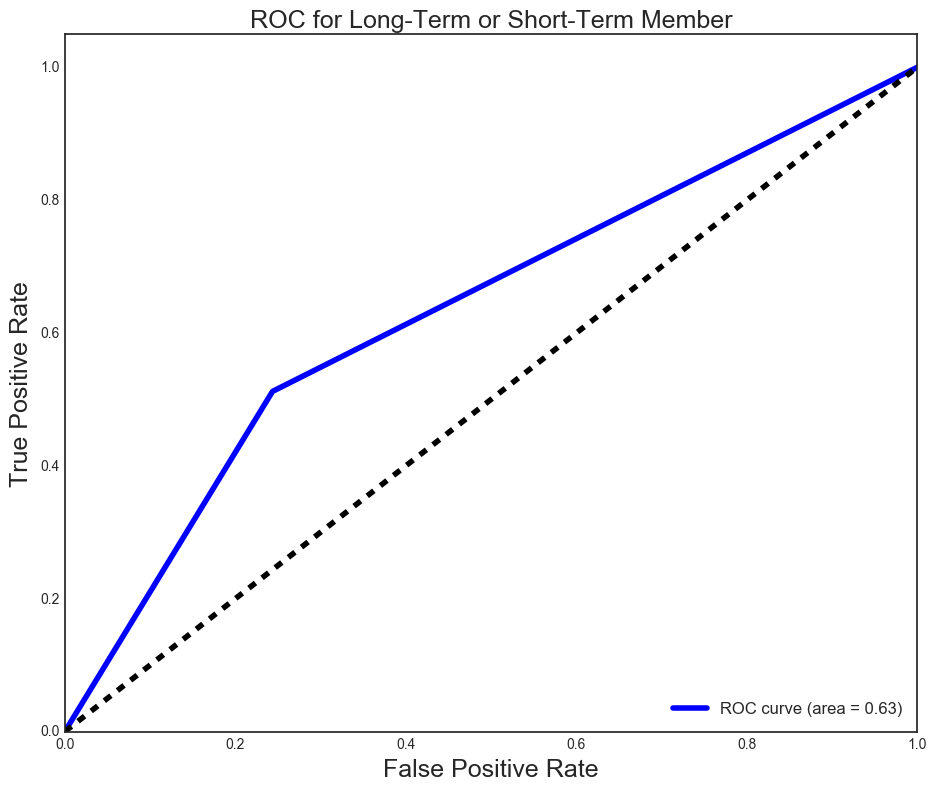

In [599]:
Y_score = logreg.decision_function(x_test)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# Find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, cv_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for Long-Term or Short-Term Member', fontsize=18)
plt.legend(loc="lower right")
plt.savefig('roc_logreg.png')
plt.show();